#Integrating a language model into your application

FastAPI is an asynchronous gateway interface (ASGI) web framework that enables you to build lean APIs and backend web servers. Being an ASGI framework means that it can leverage concurrency to process web requests.

The uvicorn package is the bare-bones web server that FastAPI runs on.

In [ ]:
!pip install "fastapi[standard]"
!pip install uvicorn

You can download and use a language model within your application with a few lines of code. In this example, you will download a TinyLlama model that has 1.1 billion parameters and is pretrained on 3 trillion tokens.

To integrate TinyLlama into your application, you can use the Hugging Face transformers library.7 You will also need to install the Pytorch deep learning framework by installing the torch package. Both packages can be installed via pip.

In [ ]:
!pip install transformers torch

#Note
If you have this error when running the server
'''
RuntimeError: Failed to import transformers.pipelines because of the following error (look up to see its traceback): Failed to import transformers.generation.utils because of the following error (look up to see its traceback): numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
'''
This means that some installed packages were compiled against a different NumPy version.

To fix it..



In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.26.4

TinyLlama can’t generate more than a few sentences at a time. You will also need around 3 GB of disk space and RAM to load this model onto memory for inference. I recommend running the model on a CUDA-enabled NVIDIA GPU (with the torch wheel compiled for CUDA) as CPU inference can be slow.

#Download and load a language model from the Hugging Face repository


In [2]:
# models.py

import torch
from transformers import Pipeline, pipeline

prompt = "How to set up a FastAPI project?"
system_prompt = """
Your name is FastAPI bot and you are a helpful
chatbot responsible for teaching FastAPI to your users.
Always respond in markdown.
"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #Check if an NVIDIA GPU is available, and if so, set device to the current CUDA-enabled GPU. Otherwise, continue using the CPU.

def load_text_model():
    pipe = pipeline(
        "text-generation",
        model="TinyLlama/TinyLlama-1.1B-Chat-v1.0",
        torch_dtype=torch.bfloat16,
        device=device
        # models.py

)
    return pipe


def generate_text(pipe: Pipeline, prompt: str, temperature: float = 0.7) -> str:
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt},
    ]
    prompt = pipe.tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    predictions = pipe(
        prompt,
        temperature=temperature,
        max_new_tokens=256,
        do_sample=True,
        top_k=50,
        top_p=0.95,
    )
    output = predictions[0]["generated_text"].split("</s>\n<|assistant|>\n")[-1]
    return output

#Serving a language model via a FastAPI endpoint

Once FastAPI and its dependencies are installed, you are ready to start your own web server. To create a simple web server that has one endpoint in FastAPI, Create a main.py file in the root of your directory,

In [ ]:
# main.py

from fastapi import FastAPI
from models import load_text_model, generate_text

app = FastAPI()

@app.get("/generate/text")
def serve_language_model_controller(prompt: str) -> str:
    pipe = load_text_model()
    output = generate_text(pipe, prompt)
    return output

You can now start the server using the fastapi dev command

In [ ]:
!uvicorn main:app --reload

Once the FastAPI service is up and running, you can visit the Swagger documentation page located at http://localhost:8000/docs to test your new endpoint:

From the Swagger docs page, you can send requests to your API to quickly test an endpoint. The docs page will also take care of sending the correct request headers, methods, and parameters.

#Connecting FastAPI with Streamlit UI generator

You can now use a web browser client in Python to visually test your service with more interactivity compared to using a command-line client.

A great Python package to quickly develop a user interface is Streamlit, which enables you to create beautiful and customizable UIs for your AI services with little effort.

Streamlit allows you to easily create a chat user interface for testing and prototyping with models. You can install the streamlit package using pip

In [ ]:
!pip install streamlit

#Streamlit chat UI consuming the FastAPI /generate endpoint

You can now start your Streamlit client application:

In [ ]:
!streamlit run client.py

You should now be able to interact with TinyLlama inside Streamlit. All of this was possible with a few short Python scripts.

The following figure shows the overall system architecture of the solution we’ve developed so far.

FastAPI service system architecture:

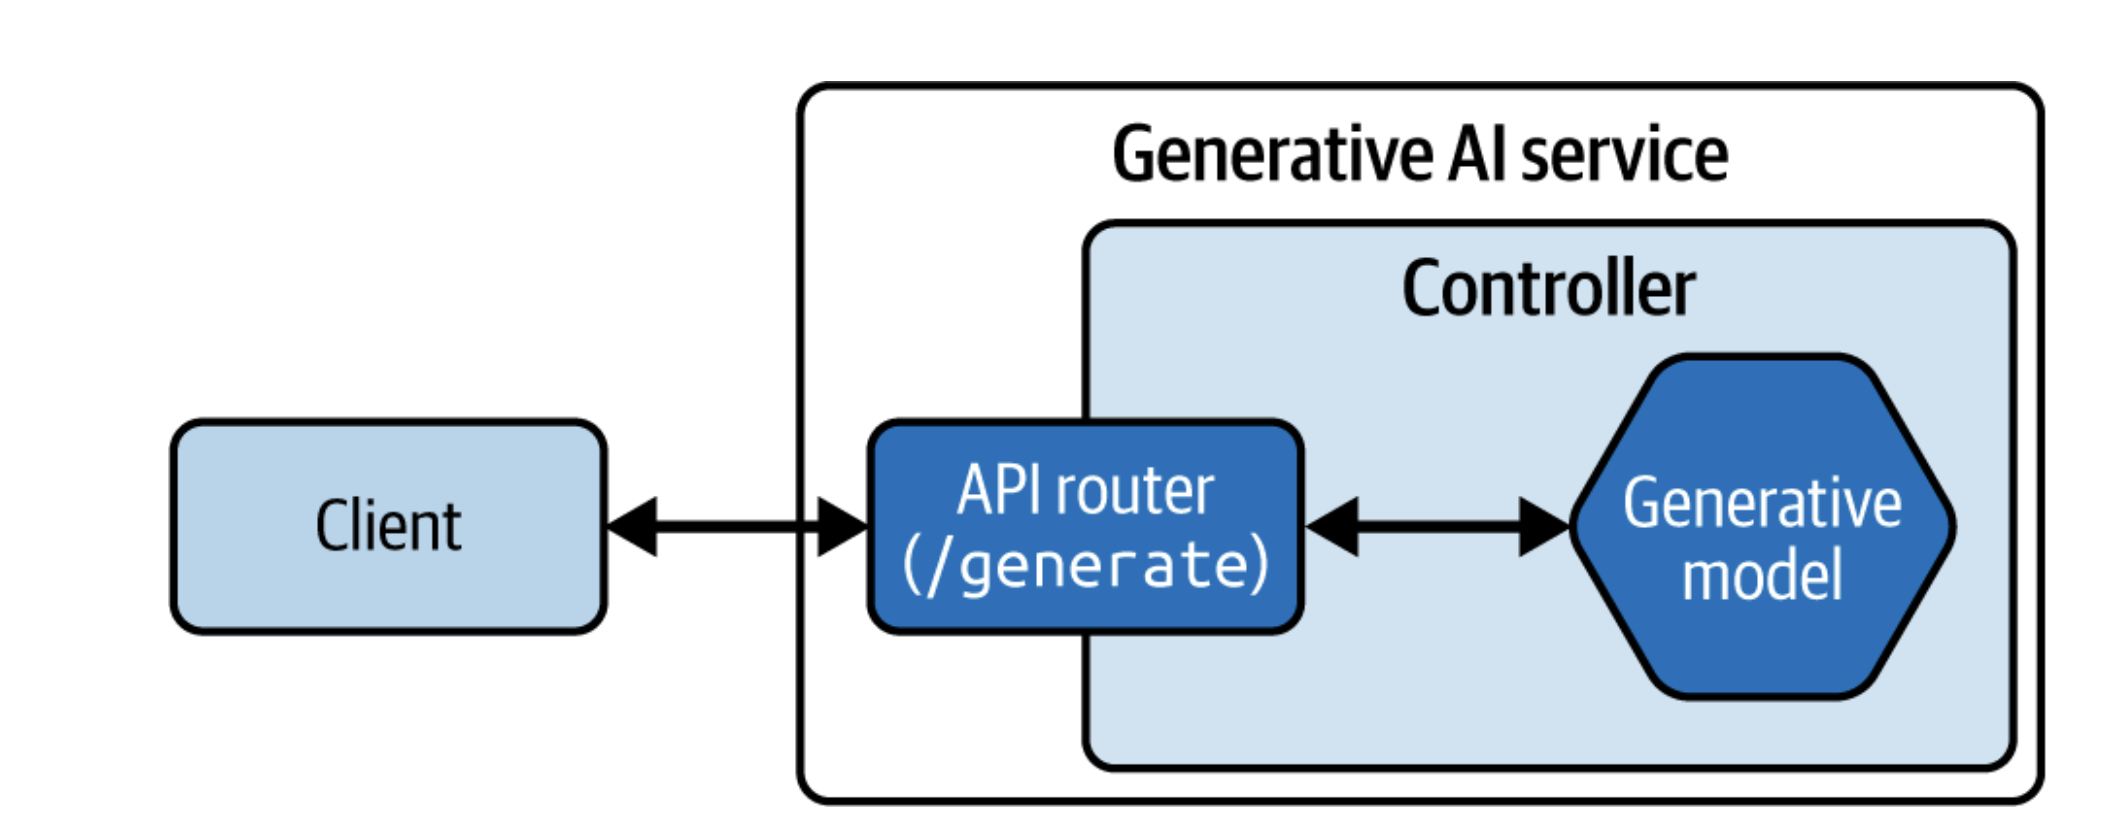